## Load libraries

In [1]:
%load_ext autoreload
%autoreload 2
import gc
import numpy as np
import os
import pickle
import random
import warnings
from math import sqrt
from datetime import datetime
from tqdm import tqdm
import ml_insights as mli
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Data processing
import pandas as pd

# Machine learning
from sklearn.metrics import (
    average_precision_score, roc_curve, 
    roc_auc_score, accuracy_score, f1_score
)
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.utils import shuffle
from sklearn.calibration import IsotonicRegression
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,roc_curve, auc
from scipy.stats import chi2

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ML
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# Visualization
import shap
import optuna

# Custom imports
from model_code import *
from model.blocks import FinalModel
from team_code import *
from helper_code import *
from plot_model import *
from delong import *

SEED = 1
warnings.filterwarnings("ignore")
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
shap.initjs()

N_TRIAL                 = 50
N_FOLD                  = 5
N_EPOCH                 = 100

BATCH_SIZE_LIST_GLOBAL  = [8,16]

LR_INITIAL_LO           = 5e-4
LR_INITIAL_HI           = 5e-3

LR_STEP_SIZE_LO         = 2
LR_STEP_SIZE_HI         = 3
LR_STEP_GAMMA_LO        = 0.05
LR_STEP_GAMMA_HI        = 0.3

EARLY_STOP_PATIENCE_LO  = 3
EARLY_STOP_PATIENCE_HI  = 4

BLOCK_SIZE_GLOBAL = [12,16,24]
BLOCK_DEPTH_GLOBAL = [2,3]
BLOCK_LAYERS_GLOBAL = [3,4]
HIDDEN_SIZE_GLOBAL = [32,64,128]
KERNEL_NUM_GLOBAL = [5,7,9]

def collate_fn(batch):
    inputs = torch.stack([torch.tensor(i[0], dtype=torch.float32) for i in batch])
    targets = torch.stack([torch.tensor(i[1], dtype=torch.float32) for i in batch])
    age = torch.tensor([[i[3]] for i in batch], dtype=torch.float32)
    gender = torch.tensor([[i[4]] for i in batch], dtype=torch.float32)

    return inputs, targets, age, gender

def youden(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

def train_model(train_loader, model, criterion, optimizer, scheduler, device=DEVICE):
    model.train()
    running_loss = 0.0
    n_batch = len(train_loader)
    pbar = tqdm(train_loader, total=n_batch, leave=False)
    torch.backends.cudnn.benchmark = True

    for batch in pbar:
        inputs, labels, age, gender = batch
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        age = age.to(device, non_blocking=True)
        gender = gender.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  
        outputs = model(inputs, age, gender)
        labels_ = labels[:, 1].unsqueeze(1)
        loss = criterion(outputs, labels_)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        del inputs, labels, age, gender, outputs, loss, labels_
    torch.backends.cudnn.benchmark = False 
    del pbar 
    return running_loss / n_batch

def evaluate_model(valid_loader, model, device=DEVICE):
    model.eval()
    model.return_hidden = True 
    y_true, y_pred, hidden_states = None, None, None
    n_batch = len(valid_loader)
    pbar = tqdm(enumerate(valid_loader), total=n_batch, leave=False)

    with torch.no_grad():
        for i_batch, (X_batch, y_true_batch, age_batch, gender_batch) in pbar:
            X_batch, y_true_batch = X_batch.to(device), y_true_batch.to(device)
            age_batch, gender_batch = age_batch.to(device), gender_batch.to(device)
            y_true_batch = y_true_batch[:, 1].unsqueeze(1)
            
            y_pred_batch, hidden_batch = model(X_batch, age_batch, gender_batch)
            y_pred_batch = F.sigmoid(y_pred_batch)
            
            y_pred_batch = y_pred_batch.cpu().numpy().reshape((-1, 1))
            y_true_batch = y_true_batch.cpu().numpy().reshape((-1, 1))
            hidden_batch = hidden_batch.cpu().numpy()
            if y_pred is None:
                y_pred = y_pred_batch
                y_true = y_true_batch
                hidden_states = hidden_batch
            else:
                y_pred = np.r_[y_pred, y_pred_batch]
                y_true = np.r_[y_true, y_true_batch]
                hidden_states = np.r_[hidden_states, hidden_batch]

            del X_batch, y_true_batch, age_batch, gender_batch, y_pred_batch, hidden_batch

            pbar.set_description(f'Evaluating ... {1 + i_batch}/{n_batch}')
    
    model.return_hidden = False 
    del pbar  
    return y_true, y_pred, hidden_states

def loguniform(low, high, size=None):
    return np.exp(np.random.uniform(np.log(low), np.log(high), size))

def calc_unreliability(y_true, y_prob, g=10):
    """
    Calculates a Hosmer-Lemeshow type statistic and p-value, 
    with some defensive checks against empty bins or p=0/1.
    """
    y_prob = np.clip(y_prob, 1e-12, 1 - 1e-12)
    
    df = pd.DataFrame({'y': y_true, 'p': y_prob})
    df['bin'] = pd.qcut(df['p'], q=g, duplicates='drop')  
    
    bin_data = df.groupby('bin', dropna=True).agg({'y': ['sum','count'], 'p': 'mean'})
    bin_data.columns = ['y_sum', 'y_count', 'p_mean']
    
    bin_data = bin_data[bin_data['y_count'] > 0]
    
    O = bin_data['y_sum']        
    N = bin_data['y_count']       
    P = bin_data['p_mean']       
    E = N * P                   
    
    hl_stat = np.sum((O - E)**2 / (N * P * (1 - P)))
    
    dof = len(bin_data) - 2
    if dof > 0:
        p_value = 1 - chi2.cdf(hl_stat, dof)
    else:
        p_value = np.nan
    return hl_stat, p_value

def seed_everything(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

def create_objective_function(model_type, model_class, param_grid_fn, features, model_name):
    def objective(trial, df_train, cv=N_FOLD):
        param_grid = param_grid_fn(trial)
        h = df_train['hid'].unique()
        groups = np.array(range(len(h)))
        h_shuffled, groups_shuffled = shuffle(h, groups, random_state=SEED)
        group_kf = GroupKFold(n_splits=cv)
        cv_scores = np.empty(cv)
        for idx, (train_h, val_h) in enumerate(group_kf.split(h_shuffled, groups=groups_shuffled)):
            X_train = df_train[df_train['hid'].isin(h_shuffled[train_h])][features]
            X_valid = df_train[df_train['hid'].isin(h_shuffled[val_h])][features]
            y_train = df_train.loc[df_train['hid'].isin(h_shuffled[train_h]), 'label'].values
            y_valid = df_train.loc[df_train['hid'].isin(h_shuffled[val_h]), 'label'].values
            
            model = model_class(**param_grid)
            if model_type == 'xgb':
                model.fit(X_train, y_train, verbose=False)
            else:
                model.fit(X_train, y_train)   
            cv_scores[idx] = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        mean_cv_score = np.mean(cv_scores)      
        try:
            if mean_cv_score > trial.study.best_value:          
                with open(f'best_params_{model_type}_{model_name}.json', 'w') as f:
                    json.dump(param_grid, f, indent=4)
        except ValueError:
            with open(f'best_params_{model_type}_{model_name}.json', 'w') as f:
                json.dump(param_grid, f, indent=4)
        return mean_cv_score
    return objective

def xgb_params(trial):
    return {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1600, 200),
        'eta': trial.suggest_float('eta', 0.005, 0.05),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.9),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1, 1e3),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 1e3),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.1, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1e2),
        'random_state': SEED,
        'enable_categorical': True
    }

def lgb_params(trial):
    return {
        'verbose':-1,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': SEED
    }

def rf_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': SEED
    }

def et_params(trial):
    return {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': SEED
    }

def compute_saliency_maps(input_data, input_age, input_gender, model):
    input_tensor = torch.FloatTensor(input_data).to(DEVICE)
    input_age_tensor = torch.FloatTensor(input_age).to(DEVICE)
    input_gender_tensor = torch.FloatTensor(input_gender).to(DEVICE)
    input_tensor.requires_grad_()
    # Forward pass
    model.eval()
    output = model(input_tensor, input_age_tensor, input_gender_tensor)
    # Compute gradients with respect to input
    output.backward(torch.ones_like(output))
    # Get gradients
    saliency = input_tensor.grad.abs().cpu().numpy()
    return saliency

def extract_date(filename):
    parts = filename.split('_')
    if len(parts) >= 3 and parts[-1].endswith('.xml') and len(parts[-1].replace('.xml','')) == 8:
        date_str = parts[-1].replace('.xml','')
        return f"{date_str[:4]}/{date_str[4:6]}/{date_str[6:8]}"
    elif len(parts) >= 4 and parts[1].isdigit() and parts[2].isdigit() and parts[3].isdigit():
        return f"{parts[1]}/{parts[2]}/{parts[3]}"
    for p in parts:
        if len(p) == 8 and p.isdigit():
            return f"{p[:4]}/{p[4:6]}/{p[6:8]}"
    return None

In [ ]:
'''
# Imports for ICD 10 code extraction
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
import json

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, droprate):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.droprate = droprate
        self.ff_dim = ff_dim
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(droprate)
        self.dropout2 = layers.Dropout(droprate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        return {'embed_dim': self.embed_dim, 'num_heads': self.num_heads, 'ff_dim':self.ff_dim, 'droprate':self.droprate}

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        return {'maxlen': self.maxlen, 'vocab_size': self.vocab_size, 'embed_dim': self.embed_dim}
        
'''

## Train Test split

In [ ]:
df = pd.read_csv('data_labels_M_N.csv')

df['date'] = df['filename'].apply(extract_date)
num_nan_dates = df['date'].isna().sum()

df['date_dt'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date_dt')

n_total = len(df)
n_test = int(np.ceil(n_total * 0.10))
test_df = df.iloc[-n_test:]
develop_df = df.iloc[:-n_test]

test_hids = set(test_df['hid'])
develop_df = develop_df[~develop_df['hid'].isin(test_hids)]

gkf = GroupKFold(n_splits=5)
folds = []
develop_idx = develop_df.index.to_numpy()
for fold_idx, (_, val_idx) in enumerate(gkf.split(develop_df, groups=develop_df['hid'])):
    fold = develop_df.iloc[val_idx]
    folds.append(fold)

for i, fold in enumerate(folds):
    overlap = set(fold['hid']) & test_hids
    assert len(overlap) == 0, f"Fold {i+1} and test set have overlapping hids: {overlap}"

for i, fold in enumerate(folds):
    np.save(f'fold_{i+1}_filenames.npy', fold['filename'].to_numpy())
np.save('test_filenames.npy', test_df['filename'].to_numpy())

## Hyperparameter tuning

In [ ]:
seed_everything(1)

study_date = datetime.now().strftime('%y%m%d')
study_folder_prefix = f'{study_date}'
study_num = 0
for folder in sorted(os.listdir('model'), reverse=True):
    if folder.startswith(study_folder_prefix):
        ch_idx = len(study_folder_prefix) + 1
        study_num = int(folder[ch_idx:ch_idx + 2]) + 1
        break
STUDY_DIR = f'model/{study_folder_prefix}_{study_num:02d}'
os.makedirs(STUDY_DIR, exist_ok=True)
search_space_train = {
    'BATCH_SIZE_LIST'       : BATCH_SIZE_LIST_GLOBAL,
    'LR_INITIAL_LO'         : LR_INITIAL_LO,
    'LR_INITIAL_HI'         : LR_INITIAL_HI,
    'LR_STEP_SIZE_LO'       : LR_STEP_SIZE_LO,
    'LR_STEP_SIZE_HI'       : LR_STEP_SIZE_HI,
    'LR_STEP_GAMMA_LO'      : LR_STEP_GAMMA_LO,
    'LR_STEP_GAMMA_HI'      : LR_STEP_GAMMA_HI,
    'EARLY_STOP_PATIENCE_LO'  : EARLY_STOP_PATIENCE_LO,
    'EARLY_STOP_PATIENCE_HI'  : EARLY_STOP_PATIENCE_HI
}
search_space_arch = {
    'BLOCK_SIZE'          : BLOCK_SIZE_GLOBAL,
    'BLOCK_DEPTH'        : BLOCK_DEPTH_GLOBAL,
    'BLOCK_LAYERS'       : BLOCK_LAYERS_GLOBAL,
    'HIDDEN_SIZE'        : HIDDEN_SIZE_GLOBAL,
    'KERNEL_NUM'         : KERNEL_NUM_GLOBAL,  
}
SEARCH_SPACE_ARCH_FILENAME  = f'{STUDY_DIR}/search_space_arch.pkl'
SEARCH_SPACE_TRAIN_FILENAME = f'{STUDY_DIR}/search_space_train.pkl'
pickle.dump(search_space_arch, open(SEARCH_SPACE_ARCH_FILENAME, 'wb'))
pickle.dump(search_space_train, open(SEARCH_SPACE_TRAIN_FILENAME, 'wb'))

fold_filenames = [np.load(f'fold_{i}_filenames.npy', allow_pickle=True) for i in range(1, 6)]

for i_trial in range(N_TRIAL):
    search_space_arch = pickle.load(open(SEARCH_SPACE_ARCH_FILENAME, 'rb'))
    search_space_train = pickle.load(open(SEARCH_SPACE_TRAIN_FILENAME, 'rb'))

    batch_size          = np.random.choice(search_space_train['BATCH_SIZE_LIST'], size=1)[0]
    lr_initial          = loguniform(low=search_space_train['LR_INITIAL_LO'], high=search_space_train['LR_INITIAL_HI'], size=1)[0]
    lr_step_size        = np.random.randint(low=search_space_train['LR_STEP_SIZE_LO'], high=search_space_train['LR_STEP_SIZE_HI'], size=1)[0]
    lr_step_gamma       = np.random.uniform(low=search_space_train['LR_STEP_GAMMA_LO'], high=search_space_train['LR_STEP_GAMMA_HI'], size=1)[0]
    early_stop_pat      = np.random.randint(low=search_space_train['EARLY_STOP_PATIENCE_LO'], high=search_space_train['EARLY_STOP_PATIENCE_HI'], size=1)[0]

    del search_space_train

    block_size             = np.random.choice(search_space_arch['BLOCK_SIZE'], size=1)[0]
    block_depth            = np.random.choice(search_space_arch['BLOCK_DEPTH'], size=1)[0]
    block_layers           = np.random.choice(search_space_arch['BLOCK_LAYERS'], size=1)[0]
    hidden_size            = np.random.choice(search_space_arch['HIDDEN_SIZE'], size=1)[0]
    kernel_num             = np.random.choice(search_space_arch['KERNEL_NUM'], size=1)[0]

    # Remove search_space_arch after use
    del search_space_arch

    trial_folder = ''
    trial_folder += f'batch={batch_size}_'
    trial_folder += f'lr={lr_initial:.5f}_step={lr_step_size}_gam={lr_step_gamma:.3f}_pat={early_stop_pat}_'
    trial_folder += f'block_size={block_size}_block_depth={block_depth}_hidden_size={hidden_size}_block_layers={block_layers}_kernel_num={kernel_num}'
    trial_dir = f'{STUDY_DIR}/{trial_folder}'
    os.makedirs(trial_dir, exist_ok=True)
    hparams_train = {
        'N_FOLD'            : N_FOLD,
        'N_EPOCH'           : N_EPOCH,
        'BATCH_SIZE'        : batch_size,
        'LR_INITIAL'        : lr_initial,
        'LR_STEP_SIZE'      : lr_step_size,
        'LR_STEP_GAMMA'     : lr_step_gamma,
        'EARLY_STOP_PAT'    : early_stop_pat,
    }
    hparams_arch = {
        'BLOCK_SIZE'        : block_size,
        'BLOCK_DEPTH'       : block_depth,
        'BLOCK_LAYERS'      : block_layers,
        'HIDDEN_SIZE'       : hidden_size,
        'KERNEL_NUM'        : kernel_num,
    }
    del batch_size, lr_initial, lr_step_size, lr_step_gamma, early_stop_pat
    del block_size, block_depth, block_layers, hidden_size, kernel_num

    print(f'RANDOM SEARCH TRIAL {1 + i_trial}/{N_TRIAL}')
    HPARAMS_TRAIN_FILENAME  = f'{trial_dir}/hparams_train.pkl'
    HPARAMS_ARCH_FILENAME   = f'{trial_dir}/hparams_arch.pkl'
    pickle.dump(hparams_train, open(HPARAMS_TRAIN_FILENAME, 'wb'))
    pickle.dump(hparams_arch, open(HPARAMS_ARCH_FILENAME, 'wb'))

    TRIAL_DIR                   = trial_dir
    TRIAL_FOLDER                = TRIAL_DIR.split('/')[-1]
    STUDY_DIR                   = TRIAL_DIR[:-(len(TRIAL_FOLDER) + 1)]
    HPARAMS_ARCH_FILENAME       = f'{TRIAL_DIR}/hparams_arch.pkl'
    HPARAMS_TRAIN_FILENAME      = f'{TRIAL_DIR}/hparams_train.pkl'
    hparams_arch    = pickle.load(open(HPARAMS_ARCH_FILENAME, 'rb'))
    BLOCK_SIZE      = int(hparams_arch['BLOCK_SIZE'])
    BLOCK_DEPTH     = int(hparams_arch['BLOCK_DEPTH'])
    BLOCK_LAYERS    = int(hparams_arch['BLOCK_LAYERS'])
    HIDDEN_SIZE     = int(hparams_arch['HIDDEN_SIZE'])
    KERNEL_NUM      = int(hparams_arch['KERNEL_NUM'])
    del hparams_arch

    hparams_train   = pickle.load(open(HPARAMS_TRAIN_FILENAME, 'rb'))
    N_FOLD          = int(hparams_train['N_FOLD'])
    N_EPOCH         = int(hparams_train['N_EPOCH'])
    BATCH_SIZE      = int(hparams_train['BATCH_SIZE'])
    LR_INITIAL      = hparams_train['LR_INITIAL']
    LR_STEP_SIZE    = hparams_train['LR_STEP_SIZE']
    LR_STEP_GAMMA   = hparams_train['LR_STEP_GAMMA']
    EARLY_STOP_PAT  = hparams_train['EARLY_STOP_PAT']
    del hparams_train

    model = FinalModel(block_size=BLOCK_SIZE, block_depth=BLOCK_DEPTH, block_layers=BLOCK_LAYERS, hidden_size=HIDDEN_SIZE, kernel_num=KERNEL_NUM).to(DEVICE)
    torch.save(model.state_dict(), f'{TRIAL_DIR}/initial_weights.pth')
    best_val_auroc_list = []

    early_stop_epochs = []
    for i_fold in range(N_FOLD):
        train_filenames = np.concatenate(fold_filenames[:i_fold] + fold_filenames[i_fold+1:])
        valid_filenames = fold_filenames[i_fold]
        train = dataset(header_files=train_filenames)
        train.num_leads = 12
        train.sample = True
        valid = dataset(header_files=valid_filenames)
        valid.num_leads = 12
        valid.sample = False
        valid.files.reset_index(drop=True, inplace=True)
        train_loader = DataLoader(train, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=True)
        valid_loader = DataLoader(valid, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False)

        model.load_state_dict(torch.load(f'{TRIAL_DIR}/initial_weights.pth', weights_only=True))
        weight_cache = f'{TRIAL_DIR}/weights_fold_{i_fold+1}.pth'
        criterion = nn.BCEWithLogitsLoss()
        optimizer = Adam(model.parameters(), lr=LR_INITIAL)
        scheduler = ReduceLROnPlateau(optimizer, patience=LR_STEP_SIZE, factor=LR_STEP_GAMMA, min_lr=1e-5, mode='max')
        best_val_auroc = 0.0
        early_stop_count = 0
        best_epoch = 0
        for epoch in range(N_EPOCH):
            print(f'FOLD {i_fold+1} - EPOCH {1 + epoch}/{N_EPOCH}')        
            train_loss = train_model(train_loader, model, criterion, optimizer, scheduler)
            y_true_valid, y_pred_valid, _ = evaluate_model(valid_loader, model)
            valid_loss = F.binary_cross_entropy(torch.FloatTensor(y_pred_valid), torch.FloatTensor(y_true_valid))
            valid_auroc = roc_auc_score(y_true_valid, y_pred_valid)
            print(f'val_auroc: {valid_auroc:.4f}')
            scheduler.step(valid_auroc)
            if valid_auroc > best_val_auroc:
                print(f'>> val_auroc increased from {best_val_auroc:.4f} to {valid_auroc:.4f}>> Saving weights to [{weight_cache}]')
                torch.save(model.state_dict(), weight_cache)
                best_val_auroc = valid_auroc
                early_stop_count = 0
                best_epoch = epoch + 1 
            else:
                early_stop_count += 1
            if early_stop_count >= EARLY_STOP_PAT:
                break
        best_val_auroc_list.append(best_val_auroc)
        early_stop_epochs.append(best_epoch if best_epoch > 0 else epoch + 1)
        del train_filenames, valid_filenames, train, valid, train_loader, valid_loader, weight_cache, criterion, optimizer, scheduler
    val_auroc_mean = np.mean(np.array(best_val_auroc_list), axis=0)

    print('*' * 100)
    for i in range(N_FOLD):
        print(f'Fold #{i}  : {best_val_auroc_list[i]:.4f} (early stop at epoch {early_stop_epochs[i]})')
    print(f'Mean : {val_auroc_mean:.4f}')
    print('*' * 100)

    weight_cache = f'{TRIAL_DIR}/weights.pth'
    develop_filenames = np.concatenate(fold_filenames)
    develop = dataset(header_files=develop_filenames)
    develop.num_leads = 12
    develop.sample = True
    develop_loader = DataLoader(develop, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False)
    avg_early_stop_epoch = int(np.round(np.mean(early_stop_epochs)))
    print(f"Training final model on develop set for {avg_early_stop_epoch} epochs (average early stopping point)")
    model.load_state_dict(torch.load(f'{TRIAL_DIR}/initial_weights.pth', weights_only=True))
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=LR_INITIAL)
    scheduler = ReduceLROnPlateau(optimizer, patience=LR_STEP_SIZE, factor=LR_STEP_GAMMA, min_lr=1e-5, mode='max')
    for epoch in range(int((avg_early_stop_epoch)*4/5)):
        print(f'DEVELOP FINAL - EPOCH {1 + epoch}/{avg_early_stop_epoch}')
        train_loss = train_model(develop_loader, model, criterion, optimizer, scheduler)
    torch.save(model.state_dict(), weight_cache)
    del develop_filenames, develop, develop_loader, criterion, optimizer, scheduler, weight_cache
    TRIAL_FOLDER_NEW = f'auc={val_auroc_mean:.4f}_{TRIAL_FOLDER}'
    TRIAL_DIR_NEW = f'{STUDY_DIR}/{TRIAL_FOLDER_NEW}'
    os.rename(TRIAL_DIR, TRIAL_DIR_NEW)
    gc.collect()

## Inference

In [3]:
trial_dir = "model/250518_00/auc=0.8646_batch=8_lr=0.00054_step=2_gam=0.164_pat=2_block_size=12_block_depth=2_hidden_size=64_block_layers=3_kernel_num=9"
TRIAL_DIR                   = trial_dir
TRIAL_FOLDER                = TRIAL_DIR.split('/')[-1]
STUDY_DIR                   = TRIAL_DIR[:-(len(TRIAL_FOLDER) + 1)]
HPARAMS_ARCH_FILENAME       = f'{TRIAL_DIR}/hparams_arch.pkl'
HPARAMS_TRAIN_FILENAME      = f'{TRIAL_DIR}/hparams_train.pkl'
hparams_arch    = pickle.load(open(HPARAMS_ARCH_FILENAME, 'rb'))
BLOCK_SIZE      = int(hparams_arch['BLOCK_SIZE'])
BLOCK_DEPTH     = int(hparams_arch['BLOCK_DEPTH'])
BLOCK_LAYERS    = int(hparams_arch['BLOCK_LAYERS'])
HIDDEN_SIZE     = int(hparams_arch['HIDDEN_SIZE'])
KERNEL_NUM      = int(hparams_arch['KERNEL_NUM'])
hparams_train   = pickle.load(open(HPARAMS_TRAIN_FILENAME, 'rb'))
N_FOLD          = int(hparams_train['N_FOLD'])
N_EPOCH         = int(hparams_train['N_EPOCH'])
BATCH_SIZE      = int(hparams_train['BATCH_SIZE'])
LR_INITIAL      = hparams_train['LR_INITIAL']
LR_STEP_SIZE    = hparams_train['LR_STEP_SIZE']
LR_STEP_GAMMA   = hparams_train['LR_STEP_GAMMA']
EARLY_STOP_PAT  = hparams_train['EARLY_STOP_PAT']

test_filenames = np.load('test_filenames.npy', allow_pickle=True)
test= dataset(header_files=test_filenames)
test.num_leads = 12
test.sample = False
test.files.reset_index(drop=True, inplace=True)
test_loader = DataLoader(test, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False)

fold_filenames = [np.load(f'fold_{i}_filenames.npy', allow_pickle=True) for i in range(1, 6)]
develop_filenames = np.concatenate(fold_filenames)
develop = dataset(header_files=develop_filenames)
develop.num_leads = 12
develop.sample = True
develop_loader = DataLoader(develop, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False)

Loading dataset: 100%|██████████| 25377/25377 [00:29<00:00, 855.02it/s]


Loading test data: 100%|██████████| 2713/2713 [00:44<00:00, 60.60it/s]


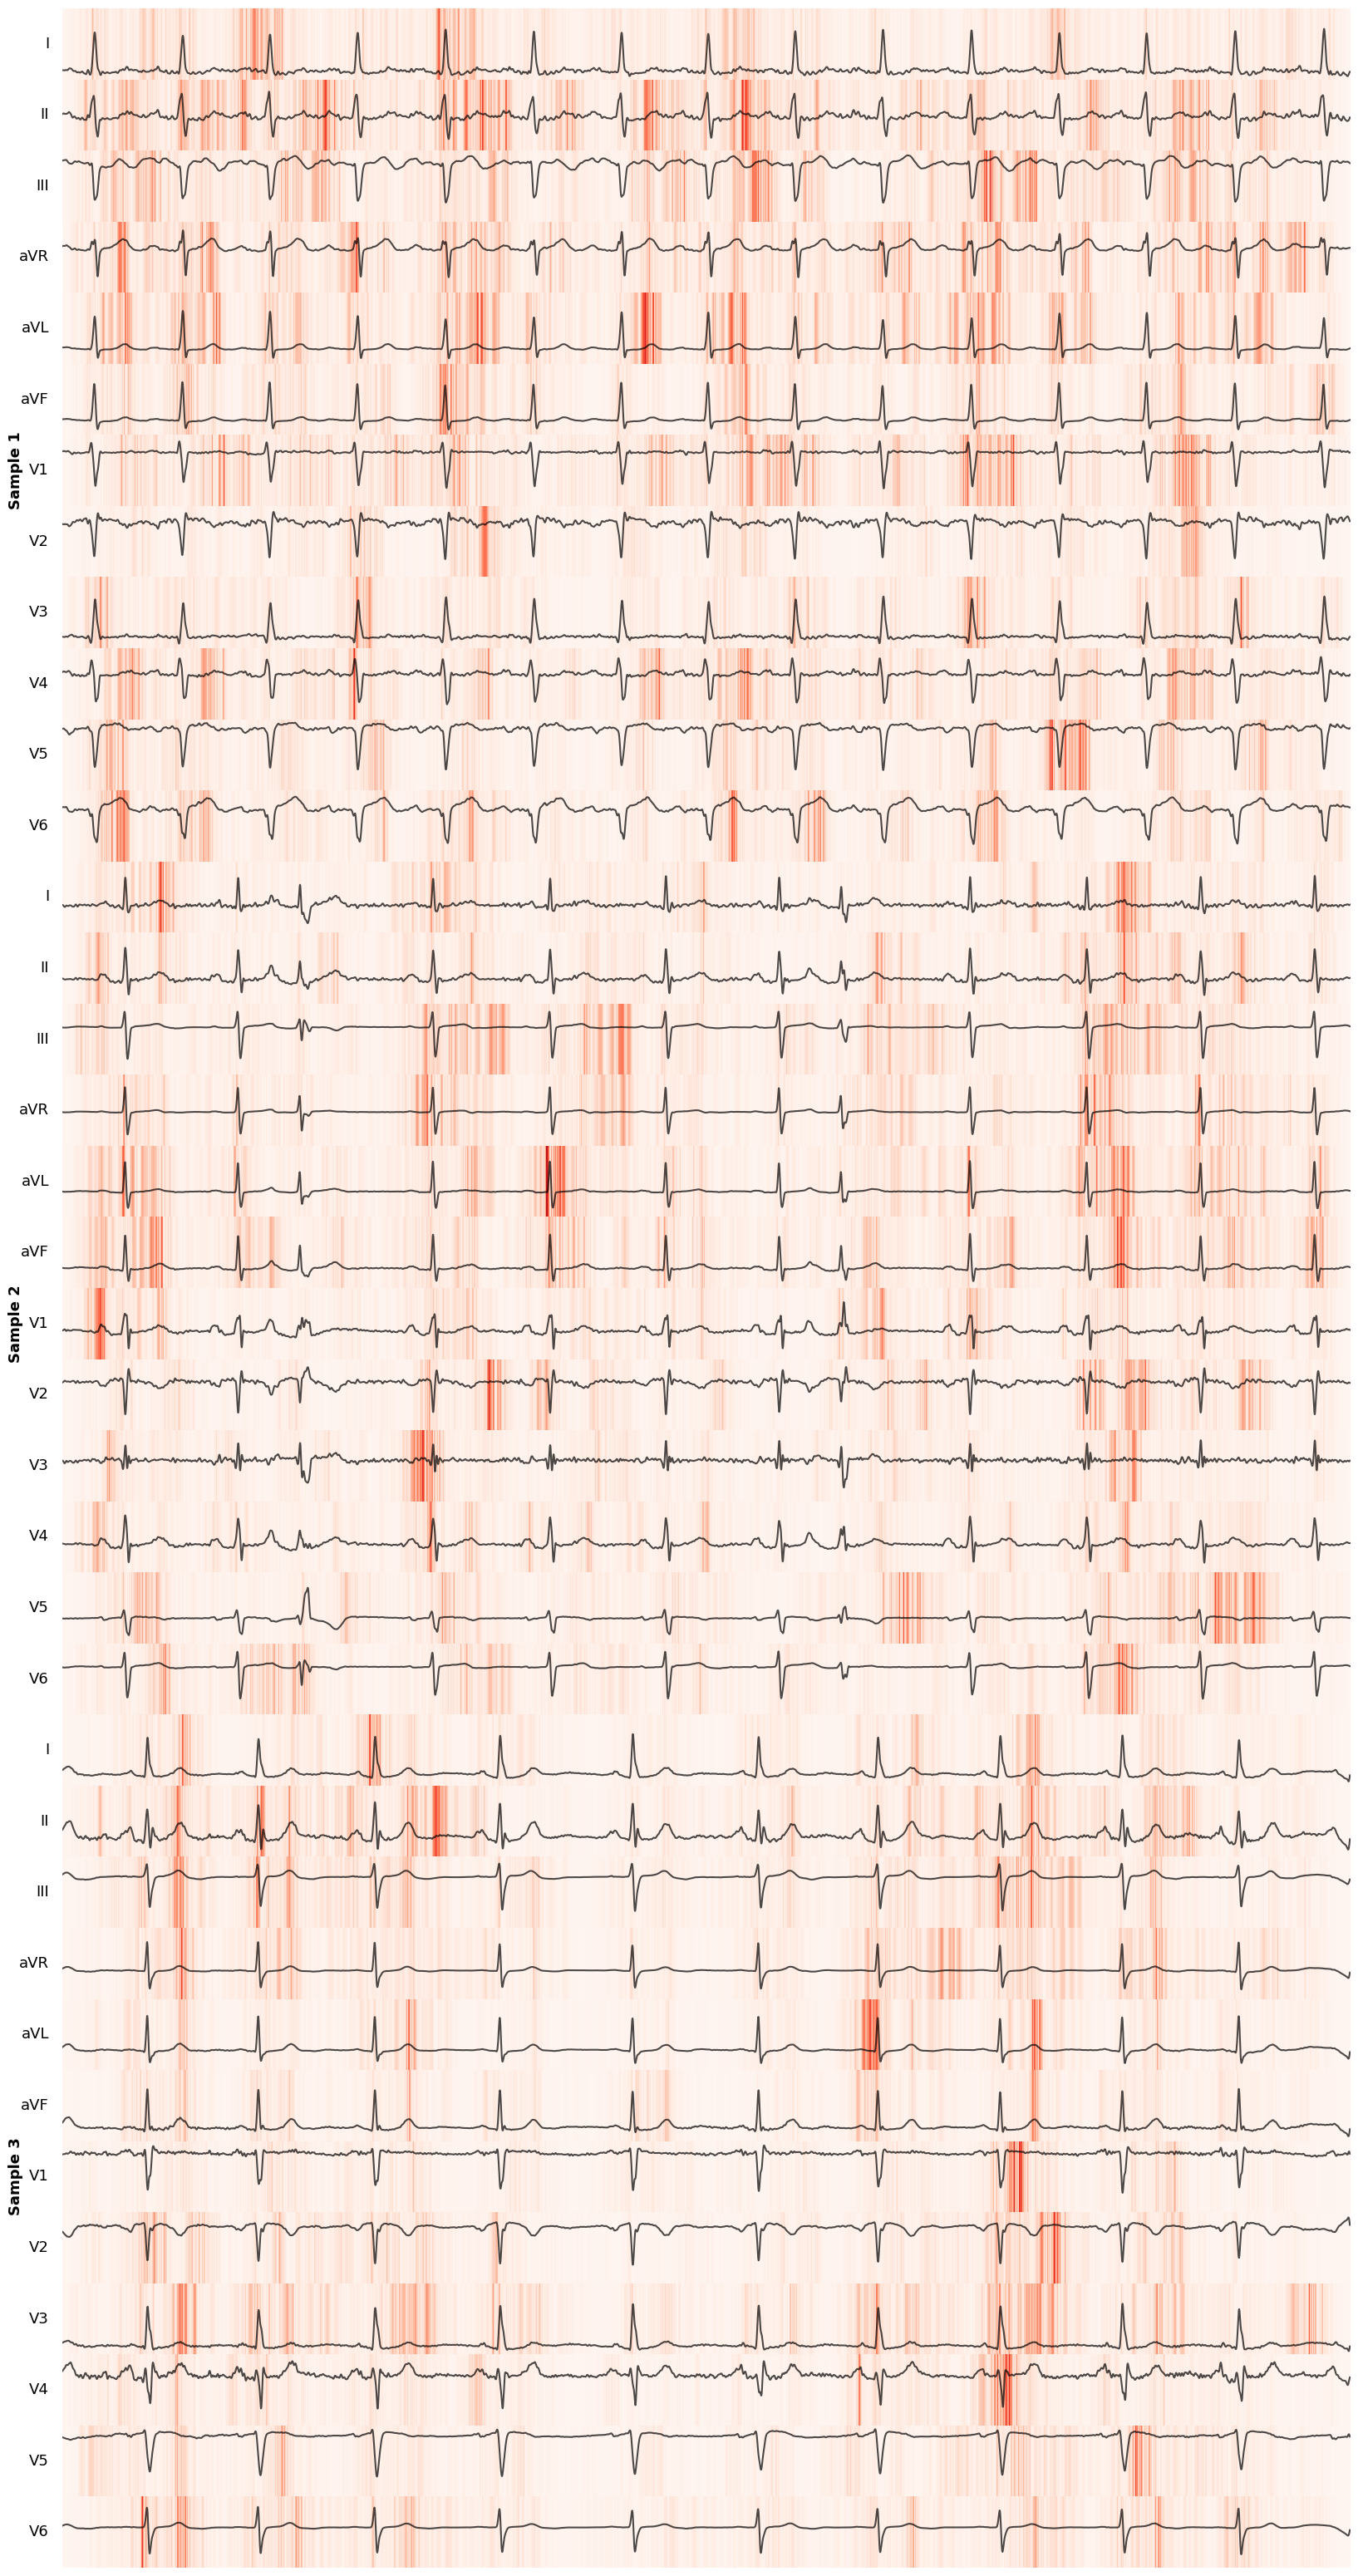

In [26]:
seed_everything(1)

all_test_data = []
all_test_labels = []
all_test_age = []
all_test_gender = []
for batch in tqdm(test_loader, desc="Loading test data"):
    data, labels, age, gender = batch
    all_test_data.append(data)
    all_test_labels.append(labels)
    all_test_age.append(age)
    all_test_gender.append(gender)
all_test_data = torch.cat(all_test_data, dim=0).numpy()
all_test_labels = torch.cat(all_test_labels, dim=0).numpy()
all_test_age = torch.cat(all_test_age, dim=0).numpy()
all_test_gender = torch.cat(all_test_gender, dim=0).numpy()
all_test_labels = np.argmax(all_test_labels, axis=1)
class_1_indices = np.where(all_test_labels == 1)[0]
selected_indices = np.random.choice(class_1_indices, 3)
test_data = all_test_data[selected_indices]
test_labels = all_test_labels[selected_indices]
test_age = all_test_age[selected_indices]
test_gender = all_test_gender[selected_indices]
torch.cuda.empty_cache()

model = FinalModel(block_size =BLOCK_SIZE, block_depth =BLOCK_DEPTH, block_layers=BLOCK_LAYERS, hidden_size=HIDDEN_SIZE, kernel_num=KERNEL_NUM).to(DEVICE)
weight_cache = f'{TRIAL_DIR}/weights.pth'
model.load_state_dict(torch.load(weight_cache, weights_only=True))
saliency_maps = compute_saliency_maps(test_data, test_age, test_gender, model)
leads = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','III', 'aVR', 'aVL', 'aVF']
lead_order = [0, 1, 8, 9, 10, 11, 2, 3, 4, 5, 6, 7]  # Maps to I,II,III,aVR,aVL,aVF,V1-V6
num_samples = 3
plt.figure(figsize=(20, 40))  
for i in range(num_samples):
    for j, lead in enumerate(lead_order):
        plt.subplot(36, 1, i*12 + j + 1)
        plt.plot(test_data[i, lead, :], color='black', alpha=0.7)
        plt.imshow(saliency_maps[i][lead].reshape(1, -1), 
                    aspect='auto', 
                    cmap=plt.cm.Reds,
                    alpha=1,    
                    vmin=0,
                    vmax=np.max(saliency_maps[i][lead]),
                    extent=[0, len(test_data[i, lead]), 
                            min(test_data[i, lead])*1.5,  
                            max(test_data[i, lead])*1.5])
        if j == 6:
            plt.text(-0.03, 0.5, f'Sample {i+1}', 
                    transform=plt.gca().transAxes,
                    rotation=90,
                    verticalalignment='center',
                    horizontalalignment='right',
                    fontsize=13,
                    fontweight='bold')
        plt.text(-0.01, 0.5, leads[lead], 
                transform=plt.gca().transAxes,
                verticalalignment='center',
                fontsize=13,
                horizontalalignment='right')
        plt.xticks([])
        plt.yticks([])
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
model = FinalModel(block_size =BLOCK_SIZE, block_depth =BLOCK_DEPTH, block_layers=BLOCK_LAYERS, hidden_size=HIDDEN_SIZE, kernel_num=KERNEL_NUM).to(DEVICE)
weight_cache = f'{TRIAL_DIR}/weights.pth'
model.load_state_dict(torch.load(weight_cache, weights_only=True))
y_true_test, y_pred_test, hidden_states = evaluate_model(test_loader, model)
test_auroc = roc_auc_score(y_true_test, y_pred_test)
y_true_test = y_true_test.ravel()  
y_pred_test = y_pred_test.ravel()  

model = FinalModel(block_size=BLOCK_SIZE, block_depth=BLOCK_DEPTH, block_layers=BLOCK_LAYERS, hidden_size=HIDDEN_SIZE, kernel_num=KERNEL_NUM).to(DEVICE)
weight_cache = f'{TRIAL_DIR}/weights.pth'
model.load_state_dict(torch.load(weight_cache, weights_only=True))
y_true_develop, y_pred_develop, hidden_states = evaluate_model(develop_loader, model)
develop_auroc = roc_auc_score(y_true_develop, y_pred_develop)
y_true_develop = y_true_develop.ravel()
y_pred_develop = y_pred_develop.ravel()

with open('y_pred_develop_cnn.pkl', 'wb') as f:
    pickle.dump(y_pred_develop, f)

cal_model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
cal_intercept, cal_slope = cal_model.intercept_, cal_model.coef_[0]
brier_before = brier_score_loss(y_true_test, y_pred_test)
U_before, p_before = calc_unreliability(y_true_test, y_pred_test)

calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500)
calib.fit(y_pred_develop, y_true_develop)
y_pred_test_cal = np.clip(calib.calibrate(y_pred_test), 1e-15, 1-1e-15)

iso_calib = IsotonicRegression(out_of_bounds='clip')
iso_calib.fit(y_pred_develop, y_true_develop)
y_pred_test_iso = np.clip(iso_calib.predict(y_pred_test), 1e-15, 1-1e-15)

cal_model = LinearRegression().fit(y_pred_test_cal.reshape(-1, 1), y_true_test)
cal_intercept_after, cal_slope_after = cal_model.intercept_, cal_model.coef_[0]
brier_after = brier_score_loss(y_true_test, y_pred_test_cal)
U_after, p_after = calc_unreliability(y_true_test, y_pred_test_cal)

cal_model_iso = LinearRegression().fit(y_pred_test_iso.reshape(-1, 1), y_true_test)
cal_intercept_iso, cal_slope_iso = cal_model_iso.intercept_, cal_model_iso.coef_[0]
brier_iso = brier_score_loss(y_true_test, y_pred_test_iso)
U_iso, p_iso = calc_unreliability(y_true_test, y_pred_test_iso)

print(f"Before Calibration:\nCalibration Intercept: {cal_intercept:.3f}\nCalibration Slope: {cal_slope:.3f}\nBrier Score: {brier_before:.3f}\nUnreliability Index: {U_before:.3f}\nUnreliability p-value: {p_before:.3f}")
print(f"\nAfter Spline Calibration:\nCalibration Intercept: {cal_intercept_after:.3f}\nCalibration Slope: {cal_slope_after:.3f}\nBrier Score: {brier_after:.3f}\nUnreliability Index: {U_after:.3f}\nUnreliability p-value: {p_after:.3f}")
print(f"\nAfter Isotonic Regression:\nCalibration Intercept: {cal_intercept_iso:.3f}\nCalibration Slope: {cal_slope_iso:.3f}\nBrier Score: {brier_iso:.3f}\nUnreliability Index: {U_iso:.3f}\nUnreliability p-value: {p_iso:.3f} \n")

Youden = youden(y_true_develop, y_pred_develop)
y_pred_label = np.array([1 if value > Youden else 0 for value in y_pred_test_cal])
draw_model_evaluation_plots(y_true_test, y_pred_test_cal, y_pred_label)

with open(f'y_test_cnn.pkl', 'wb') as f:
    pickle.dump(y_true_test, f)
with open(f'y_test_proba_cnn.pkl', 'wb') as f:
    pickle.dump(y_pred_test, f)

In [38]:
'''
df = pd.read_csv('data_labels_M_N.csv')
df2 = pd.read_csv('ecg_labels_w_features_lab_asa_3mo_N.csv')
df['andur'] = df['filename'].map(df2.set_index('filename')['andur'])
df['asa'] = df['filename'].map(df2.set_index('filename')['final_asa'])
df.to_csv('data_labels_gbm.csv', index=False)

all= dataset(header_files=df['filename'].to_list())
all.num_leads = 12
all.sample = False
all.files.reset_index(drop=True, inplace=True)
all_loader = DataLoader(all, collate_fn=collate_fn, batch_size=BATCH_SIZE, shuffle=False)
model = FinalModel(block_size =BLOCK_SIZE, block_depth =BLOCK_DEPTH, block_layers=BLOCK_LAYERS, hidden_size=HIDDEN_SIZE, kernel_num=KERNEL_NUM).to(DEVICE)
weight_cache = f'{TRIAL_DIR}/weights.pth'
model.load_state_dict(torch.load(weight_cache, weights_only=True))
y_true_test, y_pred_test, hidden_states = evaluate_model(all_loader, model)
hidden_states_df = pd.DataFrame(hidden_states, columns=[f'hidden_{i}' for i in range(HIDDEN_SIZE)])
df = pd.concat([df, hidden_states_df], axis=1)
df.to_csv('data_labels_gbm_hidden.csv', index=False)
'''

In [ ]:
'''
df3 = pd.read_csv('data_labels_gbm.csv', dtype=str)
df3 = df3.merge(pd.read_csv('transformer/all_data_labels_241106(asa_updated, opname).csv', usecols=['opname','filename'], dtype=str), how='left', on='filename')
df3['src'] = 'snuh'
df3 = df3.merge(pd.read_csv('transformer/icd10_mapping_hclee.csv', usecols=['opname', 'p', 'o', 'a'], dtype=str), how='left', on='opname')
df3['name'] = df3['opname']
df = df3.copy()
df = df.drop_duplicates(subset=['filename'], keep='first')

df = df.sample(frac=1).reset_index(drop=True)
x = np.copy(df['name'].values.astype(str))  # Convert all elements to strings
vocab_size = 4000
t_x = Tokenizer(vocab_size)
t_x.fit_on_texts(x)
x = t_x.texts_to_sequences(x)
maxlen = 158  # Instead of dynamically calculating maxlen
x = keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen)

prefix = 'transformer_res'
for target in ('p', 'o', 'a'):
    print(f'Processing {target}...')
    opath = f'transformer/{prefix}_{target}.csv'
    print('Loading tokenizer...')
    t_y = Tokenizer()
    tokenizer_config = json.loads(open(f'transformer/tokenizer_y_{target}.json').read())
    tokenizer_config = tokenizer_config['config']
    # Parse string representations back to dictionaries
    t_y.word_index = json.loads(tokenizer_config['word_index']) if isinstance(tokenizer_config['word_index'], str) else tokenizer_config['word_index']
    t_y.index_word = json.loads(tokenizer_config['index_word']) if isinstance(tokenizer_config['index_word'], str) else tokenizer_config['index_word']
    t_y.word_counts = json.loads(tokenizer_config['word_counts']) if isinstance(tokenizer_config['word_counts'], str) else tokenizer_config['word_counts']
    # Convert index_word keys to integers
    t_y.index_word = {int(k): v for k, v in t_y.index_word.items()}
    t_y.document_count = tokenizer_config['document_count']
    print('Loading model...')
    custom_objects = {
        'TokenAndPositionEmbedding': TokenAndPositionEmbedding,
        'TransformerBlock': TransformerBlock
    }
    model = keras.models.model_from_json(
        open(f'transformer/model_{target}.json').read(),
        custom_objects=custom_objects
    )
    model.load_weights(f'transformer/tuned_weights_{target}.h5')
    print('Running inference...')
    pred = model.predict(x, verbose=1)
    print('Post-processing predictions...')
    df['pred'] = pd.Series(t_y.sequences_to_texts(np.argmax(pred, axis=1)[...,None] + 1)).str.upper()
    df['conf'] = pred.max(axis=1)
    df['matched'] = (df['pred'] == df[target]).astype(int)
    print(f'Saving results to {opath}...')
    df[df['src'] == 'snuh'].drop(columns='src').to_csv(opath, index=False, encoding='utf-8-sig')
    print(f'Finished processing {target}\n')

df_a = pd.read_csv(f'transformer/{prefix}_a.csv', dtype=str, usecols=['filename', 'pred', 'matched', 'conf'])
df_o = pd.read_csv(f'transformer/{prefix}_o.csv', dtype=str, usecols=['filename', 'pred', 'matched', 'conf'])
df = pd.read_csv(f'transformer/{prefix}_p.csv', dtype=str)
df = df.merge(df_a, how='left', on='filename', suffixes=('', '_a'))
df = df.merge(df_o, how='left', on='filename', suffixes=('', '_o'))
df.rename(columns={'pred':'pred_p', 'matched':'matched_p'}, inplace=True)

df['p'] = df['p'].fillna(df['pred_p'])
df['o'] = df['o'].fillna(df['pred_o']) 
df['a'] = df['a'].fillna(df['pred_a'])

df = df[['filename', 'hid', 'age', 'gender', 'asa', 'andur', 'label', 'p', 'o', 'a']]
df2 = pd.read_csv('data_labels_gbm_hidden.csv', dtype=str)
df2 = df2.merge(df[['filename', 'p', 'o', 'a']], how='left', on='filename')
df2.to_csv('data_labels_gbm_hidden_icd.csv', index=False, encoding='utf-8-sig')
'''

In [ ]:
'''
df = pd.read_csv('data_labels_gbm_hidden_icd.csv')
xml_fields = {
    'mach_ventricular_rate': 'VentricularRate',
    'mach_atrial_rate': 'AtrialRate',
    'mach_pr_interval': 'PRInterval',
    'mach_qrs_duration': 'QRSDuration',
    'mach_qt_interval': 'QTInterval',
    'mach_qtc_interval': 'QTCorrected',
    'mach_p_axis': 'PAxis',
    'mach_r_axis': 'RAxis',
    'mach_t_axis': 'TAxis'
}
for col in xml_fields:
    df[col] = None
for idx, row in tqdm(df.iterrows(), total=len(df)):
    xml_path = 'C:/rsrch/240801_ecg_mace/data/'+row['filename']
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        # Find the RestingECGMeasurements section
        measurements = root.find('RestingECGMeasurements')
        if measurements is not None:
            for col, tag in xml_fields.items():
                elem = measurements.find(tag)
                df.at[idx, col] = elem.text if elem is not None else None
        else:
            continue
    except Exception as e:
        continue
df.to_csv('data_labels_gbm_hidden_icd.csv', index=False)
'''

In [42]:
df = pd.read_csv('data_labels_gbm_hidden_icd.csv')
df_col =[]

labels = 'label'
model_name = 'age_gender_p_o_a' # wo_cnn_, mach_/ age,andur, asa, gender, p_o_a

df['gender'] = df['gender'].astype(float)
for x in ['gender','asa','age','andur']:
   if x in model_name:
      df_col.extend([x])
if 'wo_cnn' not in model_name:
   if 'mach_' in model_name:
      df_col.extend([col for col in df.columns if 'mach_' in col])
   else:
      df_col.extend([f'hidden_{i}' for i in range(HIDDEN_SIZE)])
if 'p_o_a' in model_name:
   onehot_cols = ['p', 'o', 'a']
   onehot_df = pd.get_dummies(df[onehot_cols], prefix=onehot_cols).astype(float)
   df = df.drop(columns=onehot_cols)
   df = pd.concat([df, onehot_df], axis=1)
   df = df[df_col + list(onehot_df.columns) + ['label', 'hid', 'filename']]
else:
   df = df[df_col + ['label', 'hid', 'filename']]
df['label'] = df['label'].replace({3: 1})

test_filenames = np.load('test_filenames.npy', allow_pickle=True)
fold_filenames = [np.load(f'fold_{i}_filenames.npy', allow_pickle=True) for i in range(1, 6)]
develop_filenames = np.concatenate(fold_filenames)
df_train = df[df['filename'].isin(develop_filenames)]
df_test = df[df['filename'].isin(test_filenames)]

In [ ]:
models = {
    'xgb': create_objective_function('xgb', xgb.XGBClassifier, xgb_params, df_train.drop(columns=['hid', 'label', 'filename']).columns, model_name),
    'lgb': create_objective_function('lgb', lgb.LGBMClassifier, lgb_params, df_train.drop(columns=['hid', 'label', 'filename']).columns, model_name),
    'rf': create_objective_function('rf', RandomForestClassifier, rf_params, df_train.drop(columns=['hid', 'label', 'filename']).columns, model_name),
    'et': create_objective_function('et', ExtraTreesClassifier, et_params, df_train.drop(columns=['hid', 'label', 'filename']).columns, model_name),
}
for model_type, objective_func in models.items():
    print(f"...{model_type.upper()}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective_func(trial, df_train.drop(columns=['filename'])), n_trials=50)

In [ ]:
model_type = 'xgb' #'lgb', 'rf', 'et'
with open(f"best_params_{model_type}_{model_name}.json", 'r') as f:
    params = json.load(f)
if model_type =='xgb':
    best_model = xgb.XGBClassifier(**params)
elif model_type =='lgb':
    best_model = lgb.LGBMClassifier(**params)
elif model_type == 'rf':
    best_model = RandomForestClassifier(**params)
else:
    best_model = ExtraTreesClassifier(**params)

X_train = df_train.drop(['label', 'hid', 'filename'], axis=1)
y_train = df_train['label'].ravel()
best_model.fit(X_train, y_train)
y_train_proba = best_model.predict_proba(X_train)[:,1].ravel()

anetype = pd.read_csv('data_labels_gbm_hidden_icd_opid_anetype.csv')
anetype['anetype'] = (anetype['anetype'] == '전신').astype(int)
df_test['anetype'] = df_test['filename'].map(anetype.set_index('filename')['anetype'])

test_groups = {
    'all': df_test.drop(columns=['anetype']),
    'gen': df_test[df_test['anetype'] == 1].drop(columns=['anetype']),
    'reg': df_test[df_test['anetype'] == 0].drop(columns=['anetype'])
}

X_test = {k: v.drop(['label', 'hid','filename'], axis=1) for k, v in test_groups.items()}
y_test = {k: v['label'].ravel() for k, v in test_groups.items()}
y_test_proba = {k: best_model.predict_proba(X_test[k])[:, 1].ravel() for k in test_groups}

if model_type == 'xgb':
    feature_name_map = {
        'age': 'Age',
        'gender': 'gender',
        'p_TB': 'Body Part (Bladder)',
        'p_H0': 'Body Part (Scalp)',
        'p_0T': 'Body Part (Spinal Meninges)',
        'p_DQ': 'Body Part (Anus)',
        'p_32': 'Body Part (Innominate Artery)',
        'p_U9': 'Body Part (Uterus)',
        'o_C': 'Operation (Extirpation)',
        'o_B': 'Operation (Excision)',
        'o_J': 'Operation (Inspection)',
        'o_Q': 'Operation (Repair)',
        'o_Y': 'Operation (Transplantation)',
        'o_9': 'Operation (Drainage)',
        'a_0': 'Approach (Open)',
        'a_8': 'Approach (Endoscopic via Opening)',
        'hidden_3': 'Hidden unit 3',
        'hidden_22': 'Hidden unit 22',
        'hidden_58': 'Hidden unit 58',
        'hidden_5': 'Hidden unit 5'
    }
    display_feature_names = [
        feature_name_map.get(col, col) for col in X_test['all'].columns
    ]
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test['all'])
    shap.summary_plot(shap_values, X_test['all'], feature_names=display_feature_names)

cal_model = LinearRegression().fit(y_test_proba['all'].reshape(-1,1), y_test['all'])
cal_intercept, cal_slope = cal_model.intercept_, cal_model.coef_[0]
brier_before = brier_score_loss(y_test['all'], y_test_proba['all'])
U_before, p_before = calc_unreliability(y_test['all'], y_test_proba['all'])

calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500)
calib.fit(y_train_proba,y_train)
y_test_proba_cal = {k: calib.calibrate(y_test_proba[k]) for k in test_groups}
cal_model_after = LinearRegression().fit(y_test_proba_cal['all'].reshape(-1,1), y_test['all'])
cal_intercept_after, cal_slope_after = cal_model_after.intercept_, cal_model_after.coef_[0]
brier_after = brier_score_loss(y_test['all'],y_test_proba_cal['all'])
U_after, p_after = calc_unreliability(y_test['all'], y_test_proba_cal['all'])

iso_calib = IsotonicRegression(out_of_bounds='clip').fit(y_train_proba,y_train)
y_test_proba_iso = iso_calib.predict(y_test_proba['all'])
cal_model_iso = LinearRegression().fit(y_test_proba_iso.reshape(-1,1), y_test['all'])
cal_intercept_iso, cal_slope_iso = cal_model_iso.intercept_, cal_model_iso.coef_[0]
brier_iso = brier_score_loss(y_test['all'], y_test_proba_iso)
U_iso, p_iso = calc_unreliability(y_test['all'], y_test_proba_iso)

print(f"Before Calibration:\nCalibration Intercept: {cal_intercept:.3f}\nCalibration Slope: {cal_slope:.3f}\nBrier Score: {brier_before:.3f}\nUnreliability Index: {U_before:.3f}\nUnreliability p-value: {p_before:.3f}")
print(f"\nAfter Spline Calibration:\nCalibration Intercept: {cal_intercept_after:.3f}\nCalibration Slope: {cal_slope_after:.3f}\nBrier Score: {brier_after:.3f}\nUnreliability Index: {U_after:.3f}\nUnreliability p-value: {p_after:.3f}")
print(f"\nAfter Isotonic Regression:\nCalibration Intercept: {cal_intercept_iso:.3f}\nCalibration Slope: {cal_slope_iso:.3f}\nBrier Score: {brier_iso:.3f}\nUnreliability Index: {U_iso:.3f}\nUnreliability p-value: {p_iso:.3f}\n")

Youden = youden(y_train, y_train_proba)
y_pred = {k: (y_test_proba_cal[k] > Youden).astype(int) for k in test_groups}

print(f"Youden: {Youden:.3f}")
draw_model_evaluation_plots(y_test['all'], y_test_proba_cal['all'], y_pred['all'])
print("<Subgroup: General Anesthesia>")
draw_model_evaluation_plots(y_test['gen'], y_test_proba_cal['gen'], y_pred['gen'])
print("<Subgroup: Regional Anesthesia>")
draw_model_evaluation_plots(y_test['reg'], y_test_proba_cal['reg'], y_pred['reg'])


with open(f'Youden_{model_name}.pkl', 'wb') as f:
    pickle.dump(Youden, f)
with open(f'y_test_{model_type}_{model_name}.pkl', 'wb') as f:
    pickle.dump(y_test['all'], f)
with open(f'y_test_proba_{model_type}_{model_name}.pkl', 'wb') as f:
    pickle.dump(y_test_proba_cal['all'], f)


with open(f'y_test_proba_xgb_age_gender_p_o_a.pkl', 'rb') as f:
    y_test_proba_xgb_age_gender_p_o_a = pickle.load(f)

print(f"Delong's P: {delong_roc_test(y_test['all'], y_test_proba_xgb_age_gender_p_o_a, y_test_proba_cal['all'])[0][0]:.3f}")
print(f"AUPRC (Paired T-test): {auprc_test(y_test['all'], y_test_proba_xgb_age_gender_p_o_a, y_test_proba_cal['all']):.3f}\n")

## Multimodal GBM, Baseline GBM, ECG GBM, ASA, RCRI

In [ ]:
df = pd.read_csv('data_labels_gbm_hidden_icd.csv')
df_col =[]
labels = 'label'
model_name = 'age_gender_p_o_a' # wo_cnn_, mach_/ age,andur, asa, gender, p_o_a
df['gender'] = df['gender'].astype(float)
for x in ['gender','asa','age','andur']:
   if x in model_name:
      df_col.extend([x])
if 'wo_cnn' not in model_name:
   if 'mach_' in model_name:
      df_col.extend([col for col in df.columns if 'mach_' in col])
   else:
      df_col.extend([f'hidden_{i}' for i in range(HIDDEN_SIZE)])
if 'p_o_a' in model_name:
   onehot_cols = ['p', 'o', 'a']
   onehot_df = pd.get_dummies(df[onehot_cols], prefix=onehot_cols).astype(float)
   df = df.drop(columns=onehot_cols)
   df = pd.concat([df, onehot_df], axis=1)
   df = df[df_col + list(onehot_df.columns) + ['label', 'hid', 'filename']]
else:
   df = df[df_col + ['label', 'hid', 'filename']]
df['label'] = df['label'].replace({3: 1})

rcri= pd.read_csv('rcri_missing.csv')
opid = pd.read_csv('opid_icd_matching.csv')
df['opid'] = df['filename'].map(dict(zip(opid['filename'], opid['opid'])))
df['rcri'] = df['opid'].map(dict(zip(rcri['opid'], rcri['rcri_score'])))
df = df[df['rcri'].notna()]

test_filenames = np.load('test_filenames.npy', allow_pickle=True)
fold_filenames = [np.load(f'fold_{i}_filenames.npy', allow_pickle=True) for i in range(1, 6)]
develop_filenames = np.concatenate(fold_filenames)
df_train = df[df['filename'].isin(develop_filenames)]
df_test = df[df['filename'].isin(test_filenames)]
df_train.drop(columns=['filename'], inplace=True)
df_test.drop(columns=['filename'], inplace=True)

with open(f'y_test_proba_xgb_age_gender_p_o_a.pkl', 'rb') as f:
    df_test['y_test_proba_xgb_age_gender_p_o_a'] = pickle.load(f)
with open(f'y_test_proba_xgb_wo_cnn_age_gender_p_o_a.pkl', 'rb') as f:
    df_test['y_test_proba_xgb_wo_cnn_age_gender_p_o_a'] = pickle.load(f)
with open(f'y_test_proba_xgb_.pkl', 'rb') as f:
    df_test['y_test_proba_xgb_'] = pickle.load(f)

print("<ASA>")
Youden_ASA = youden(df_train['label'], df_train['asa'])
print(f"Youden ASA: {Youden_ASA}")
df_test['asa_pred'] = [1 if value > Youden_ASA else 0 for value in df_test['asa']]
draw_model_evaluation_plots(df_test['label'].ravel(),df_test['asa'].ravel() , df_test['asa_pred'].ravel())
print(f"ASA (Delong's P): {delong_roc_test(df_test['label'], df_test['y_test_proba_xgb_age_gender_p_o_a'], df_test['asa'])[0][0]:.3f}")
print(f"ASA (AUPRC): {auprc_test(df_test['label'], df_test['y_test_proba_xgb_age_gender_p_o_a'], df_test['asa']):.3f}\n")
print("<RCRI>")
Youden_RCRI = youden(df_train['label'], df_train['rcri'])
print(f"Youden RCRI: {Youden_RCRI}")
df_test['rcri_pred'] = [1 if value > Youden_RCRI else 0 for value in df_test['rcri']]
draw_model_evaluation_plots(df_test['label'].ravel(),df_test['rcri'].ravel() , df_test['rcri_pred'].ravel())
print(f"RCRI (Delong's P): {delong_roc_test(df_test['label'], df_test['y_test_proba_xgb_age_gender_p_o_a'], df_test['rcri'])[0][0]:.3f}")
print(f"RCRI (AUPRC): {auprc_test(df_test['label'], df_test['y_test_proba_xgb_age_gender_p_o_a'], df_test['rcri']):.3f}\n")

plt.figure(figsize=(8, 8))
fpr_mm, tpr_mm, _ = roc_curve(df_test['label'], df_test['y_test_proba_xgb_age_gender_p_o_a'])
auc_mm = auc(fpr_mm, tpr_mm)
plt.plot(fpr_mm, tpr_mm, color='blue', lw=2, label=f'Multimodal GBM (AUC = {auc_mm:.3f})')
fpr_base, tpr_base, _ = roc_curve(df_test['label'], df_test['y_test_proba_xgb_wo_cnn_age_gender_p_o_a'])
auc_base = auc(fpr_base, tpr_base)
plt.plot(fpr_base, tpr_base, color='orange', lw=2, label=f'Baseline GBM (AUC = {auc_base:.3f})')
fpr_ecg, tpr_ecg, _ = roc_curve(df_test['label'], df_test['y_test_proba_xgb_'])
auc_ecg = auc(fpr_ecg, tpr_ecg)
plt.plot(fpr_ecg, tpr_ecg, color='green', lw=2, label=f'ECG-only GBM (AUC = {auc_ecg:.3f})')
fpr_rcri, tpr_rcri, _ = roc_curve(df_test['label'], df_test['rcri'])
auc_rcri = auc(fpr_rcri, tpr_rcri)
plt.plot(fpr_rcri, tpr_rcri, color='red', lw=2, label=f'RCRI (AUC = {auc_rcri:.3f})')
fpr_asa, tpr_asa, _ = roc_curve(df_test['label'], df_test['asa'])
auc_asa = auc(fpr_asa, tpr_asa)
plt.plot(fpr_asa, tpr_asa, color='purple', lw=2, label=f'ASA (AUC = {auc_asa:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Multimodal GBM, TnI

In [ ]:
df = pd.read_csv('data_labels_gbm_hidden_icd.csv')
df_col =[]
labels = 'label'
model_name = 'age_gender_p_o_a' # wo_cnn_, mach_/ age,andur, asa, gender, p_o_a
df['gender'] = df['gender'].astype(float)
for x in ['gender','asa','age','andur']:
   if x in model_name:
      df_col.extend([x])
if 'wo_cnn' not in model_name:
   if 'mach_' in model_name:
      df_col.extend([col for col in df.columns if 'mach_' in col])
   else:
      df_col.extend([f'hidden_{i}' for i in range(HIDDEN_SIZE)])
if 'p_o_a' in model_name:
   onehot_cols = ['p', 'o', 'a']
   onehot_df = pd.get_dummies(df[onehot_cols], prefix=onehot_cols).astype(float)
   df = df.drop(columns=onehot_cols)
   df = pd.concat([df, onehot_df], axis=1)
   df = df[df_col + list(onehot_df.columns) + ['label', 'hid', 'filename']]
else:
   df = df[df_col + ['label', 'hid', 'filename']]
df['label'] = df['label'].replace({3: 1})

test_filenames = np.load('test_filenames.npy', allow_pickle=True)
fold_filenames = [np.load(f'fold_{i}_filenames.npy', allow_pickle=True) for i in range(1, 6)]
develop_filenames = np.concatenate(fold_filenames)

tni = pd.read_csv('opid_troponin_orig.csv')
opid = pd.read_csv('opid_icd_matching.csv')
df['opid'] = df['filename'].map(dict(zip(opid['filename'], opid['opid'])))
df['tni'] = df['opid'].map(dict(zip(tni['opid'], tni['pre_troponin_I'])))

test_filenames = np.load('test_filenames.npy', allow_pickle=True)
df_train = df.loc[~df['filename'].isin(test_filenames)]

df = df[df['tni'].notna()]
df_train_tni = df.loc[~df['filename'].isin(test_filenames)]
df_test = df.loc[df['filename'].isin(test_filenames)]

with open(f"best_params_xgb_{model_name}.json", 'r') as f:
    params = json.load(f)
best_model = xgb.XGBClassifier(**params)

X_train = df_train.drop(['label', 'hid', 'filename', 'tni', 'opid'], axis=1)
y_train = df_train['label'].ravel()
y_train_tni = df_train_tni['label'].ravel()
best_model.fit(X_train, y_train)
y_train_proba = best_model.predict_proba(X_train)[:,1].ravel()

df_train.drop(columns=['filename'], inplace=True)
df_test.drop(columns=['filename'], inplace=True)

print(f"Number of test set: {len(df_test)}")

X_test = df_test.drop(['label', 'hid','tni','opid'], axis=1)
y_test = df_test['label'].ravel()
y_test_proba = best_model.predict_proba(X_test)[:,1].ravel()

calib = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500)
calib.fit(y_train_proba, y_train)
calib_tni = mli.SplineCalib(unity_prior=False, unity_prior_weight=100, random_state=42, max_iter=500)
calib_tni.fit(df_train_tni['tni'].ravel(), y_train_tni)

y_test_proba_cal = calib.calibrate(y_test_proba)
y_test_proba_cal_tni = calib_tni.calibrate(df_test['tni'])

Youden = youden(y_train, y_train_proba)
Youden_tni = youden(y_train_tni, df_train_tni['tni'])
y_pred = (y_test_proba_cal > Youden).astype(int)
y_pred_tni = (y_test_proba_cal_tni > Youden_tni).astype(int)

print(f"Youden: {Youden:.3f}")
print("<Multimodal GBM>")
draw_model_evaluation_plots(y_test, y_test_proba_cal, y_pred)
print("<Troponin I>")
draw_model_evaluation_plots(y_test, y_test_proba_cal_tni, y_pred_tni, draw=False)

fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_test_proba_cal)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)
fpr_tni, tpr_tni, _ = roc_curve(y_test, y_test_proba_cal_tni)
roc_auc_tni = auc(fpr_tni, tpr_tni)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm, tpr_gbm, color='blue', lw=2, label=f"Multimodal GBM (AUROC = {roc_auc_gbm:.3f})")
plt.plot(fpr_tni, tpr_tni, color='orange', lw=2, label=f"TnI (AUROC = {roc_auc_tni:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"Delong's P: {delong_roc_test(y_test, y_test_proba_cal, y_test_proba_cal_tni)[0][0]:.3f}")
print(f"AUPRC P: {auprc_test(y_test, y_test_proba_cal,y_test_proba_cal_tni):.3f}\n")